# About run_sequence_analysis

This notebook creates dividies students into groups, loads their action sequences and runs the infogain analysis

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10,6
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
from tabulate import tabulate
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading data

We grab the student learning data

In [2]:
df_all = get_df_all_factors(all_vars=True)
variables = list(set(df_all['variable']))
ids = list(set(df_all['sid']))
N = len(ids)
print 'We have',N,'students.'
print 'Running the analaysis on the following variables:',', '.join(variables)

We have 147 students.
Running the analaysis on the following variables: Battery voltage, Area, Width, Separation, Wavelength, Concentration


We grab the sequences

In [3]:
import pickle
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
pickle_in_blocked_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_blocked_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
all_blocked_seqs = pickle.load(pickle_in_blocked_seqs)
pickle_in_seqs.close()
pickle_in_blocked_seqs.close()

# Splitting students

## Count number of "exact" main scores

In [12]:
df_all.head(6)

,sid,sim,variable,pre,main,cvs_graph,cvs_table,cvs_table_only,cvs_graph_inverse,cvs_graph_axes,qual_score,quant_score,activity_order,sim_index,similar_sim,lab_experience,lab_experience_chem,lab_experience_phys,prior_number_virtual_labs,overall POCC,PC1,PC2,pre_with_ident,main_with_ident,CVS_context,use_table,use_graph,use_concentration,use_width,use_area,use_separation,use_all_vars,use_graph_beers,use_table_beers,use_table_capacitor,use_graph_capacitor
0,10127163,L,Concentration,0.0,2.0,1,1,0,0,1,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
1,10127163,L,Wavelength,0.0,0.0,1,1,0,0,1,1.0,NaN,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,1.0,2,1,1,1,1,1,1,4,1,1,1,1
2,10127163,L,Width,0.0,2.0,1,1,0,0,1,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
3,10127163,C,Area,2.0,2.0,1,1,0,0,1,1.0,1.0,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
4,10127163,C,Separation,2.0,2.0,1,1,0,1,2,1.0,1.0,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
5,10127163,C,Battery voltage,2.0,2.0,0,1,1,0,0,NaN,NaN,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,1,1,1,1,1,1,1,4,1,1,1,1


In [5]:
def count_exact(scores):
    return int(sum([s==2.0 for s in scores]))

In [6]:
scores = pd.pivot_table(df_all, values=['pre','main'], index='sid', aggfunc=count_exact)
scores.reset_index().set_index('sid',inplace=True)
scores.head()

,main,pre
sid,,
10127163,5.0,3.0
10192168,1.0,0.0
10232160,2.0,0.0
10375163,2.0,0.0
10420167,3.0,1.0


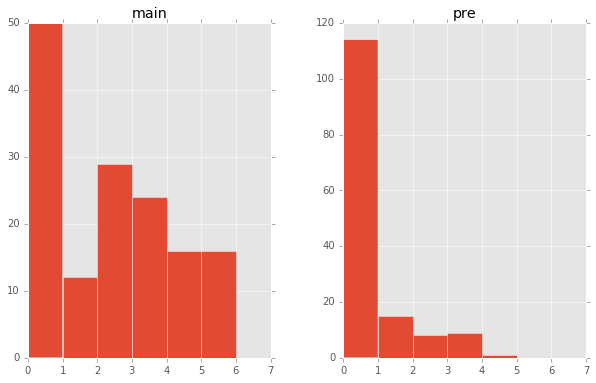

In [7]:
scores.hist(bins=range(8));

In [8]:
print 'median', np.median(scores['main'])
print 'mean', np.mean(scores['main'])
print 'std', np.std(scores['main'])

median 2.0
mean 1.94557823129
std 1.73707985837


## What if we split by those who had at least one instance of pre=2

In [9]:
def make_pre_group(row):
    if row['pre']>0:
        return 'H'
    else:
        return 'L'
def make_main_group(row):
    if row['main']>0:
        return 'H'
    else:
        return 'L'
scores['pre_group'] = scores.apply(make_pre_group,axis=1)
scores['main_group'] = scores.apply(make_main_group,axis=1)

In [11]:
scores.groupby(['pre_group','main_group']).describe()

main                                         pre        \
                     count  mean   std  min  25%  50%   75%  max count  mean   
pre_group main_group                                                           
H         H           31.0  3.52  1.23  1.0  3.0  3.0  5.00  5.0  31.0  1.87   
          L            2.0  0.00  0.00  0.0  0.0  0.0  0.00  0.0   2.0  2.00   
L         H           66.0  2.68  1.22  1.0  2.0  2.0  3.75  5.0  66.0  0.00   
          L           48.0  0.00  0.00  0.0  0.0  0.0  0.00  0.0  48.0  0.00   

                                                     
                       std  min  25%  50%  75%  max  
pre_group main_group                                 
H         H           0.92  1.0  1.0  2.0  3.0  4.0  
          L           1.41  1.0  1.5  2.0  2.5  3.0  
L         H           0.00  0.0  0.0  0.0  0.0  0.0  
          L           0.00  0.0  0.0  0.0  0.0  0.0

## What if we split by learning gains

We use the following formula for learning gains:

$gain = \frac{main-pre}{max\_score-pre}$

where max_score is the number of variables

In [38]:
max_score = len(variables)
scores['gains'] = (scores['main']-scores['pre'])/(max_score - scores['pre'])
t = scores['gains'].value_counts().sort_index()
t

-1.00     1
-0.33     1
-0.20     1
 0.00    53
 0.17    10
 0.20     1
 0.25     2
 0.33    28
 0.40     7
 0.50    16
 0.60     2
 0.67    13
 0.75     3
 0.80     2
 0.83     7
Name: gains, dtype: int64

* LN 56 students had null or negative learning gains (53+1+1+1)
* LL 38 students had small learning gains (10+1+12+28+7)
* LH 43 students had large learning gain on 50% or more (16+13+2+3+2+7)

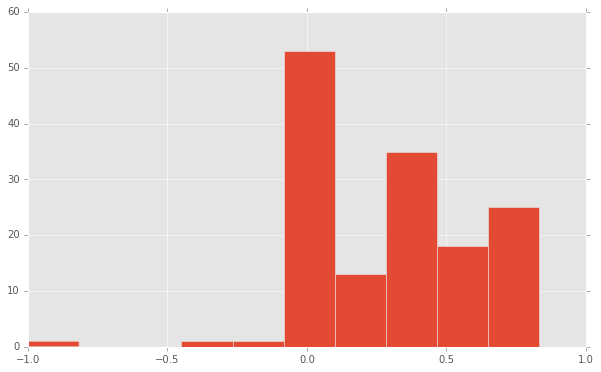

In [39]:
scores['gains'].hist()

# Todo

* get time coordinates
* run sequence analysis